In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import requests
import json

### Importing main file 'papers.csv'

In [44]:
df=pd.read_csv('papers.csv')
print(len(df))
print(df.columns)

49317
Index(['Conference', 'Year', 'Title', 'Author', 'Affiliation'], dtype='object')


In [45]:
# dataframe for doing citations related analysis
df_citations=pd.DataFrame(columns=df.columns)

#### Merging the papers with same title 

In the given dataset if a paper has multiple authors than it is repeated for each author. So, we are merging the papers with same title and creating a new dataset. 

In [46]:
i=0
while i<len(df):
    title=df.loc[i,'Title']
    ct=i
    conf=df.loc[i,'Conference']
    year=df.loc[i,'Year']
    authors=[]
    aff=[]
    while ct<len(df) and df.loc[ct,'Title']==title:
        authors.append(df.loc[ct,'Author'])
        aff.append(df.loc[ct,'Affiliation'])
        i=i+1
        ct=ct+1
    df_citations.loc[len(df_citations)]=[conf,year,title,authors,aff]

### Getting citations for each paper from title using Semantic Scholar API

Using Semantic Scholar API we are getting the citations for each paper from title. However due to limit on number of requests we can make to the API and time it consumes to get Id from the title and citations from id we are only getting citations for paper belonging to year 2006-2012. 


In [11]:
error_rate=0
citation_graph=pd.DataFrame(columns=['PaperId','Cited_PaperId'])
for i in tqdm.trange(len(df_citations[df_citations['Year']<=2012])):
    title=df_citations.loc[i,'Title']
    try:
        # getting id by title
        query="http://api.semanticscholar.org/graph/v1/paper/search?query="+title
        req=requests.get(query)
        response=req.json()
        id=response['data'][0]['paperId']
        citation_graph.loc[i]=[id,[]]

        # getting citations by id
        search_by_id="https://api.semanticscholar.org/graph/v1/paper/"+id+"?fields=title,citations.authors,authors"
        req=requests.get(search_by_id)
        response=dic2=json.loads(req.content.decode('utf-8'))
        
        for citation in response['citations']:
            citation_graph.loc[i,'Cited_PaperId'].append(citation['paperId'])
        
    except:
        error_rate=error_rate+1
    if(i%100==0):
        print(error_rate/(i+1))
        citation_graph.to_csv('citation_graph_2012.csv',index=False)

print(error_rate/len(df_citations[df_citations['Year']<=2012]))
# citation_graph.to_csv('citation_graph_2012.csv',index=False)


100%|██████████| 1899/1899 [1:44:32<00:00,  3.30s/it]  


0.2553975776724592


We were able to get citations for around 1400 papers from around 1800 papers belonging to year 2006-2012. The reason for not getting citations for all the papers is that some of the papers are not present in the Semantic Scholar database.

In [ ]:
# citation_graph.to_csv('citation_graph_2012.csv',index=False)
# this file with used later to after mapping countries to papers

###  Getting country of each paper 
'paper_with_country.csv' already contains the country of each paper. We will map the title of paper to a country. However in cases when when a paper has multiple authors belonging to different countries we will assign majority country to the paper.



In [48]:
country = pd.read_csv('citation_data/papers_with_country.csv')
country_till_2012=country[country['Year']<=2012]

In [49]:
country_till_2012['PaperId']=np.nan

C:\Users\Sandeep\AppData\Local\Temp\ipykernel_17168\3755489797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_till_2012['PaperId']=np.nan


In [66]:
title_to_id={}
unique_titles=country_till_2012['Title'].unique()

In [ ]:

error_rate=0
for i in tqdm.trange(len(unique_titles)):
    title=unique_titles[i]
    url="http://api.semanticscholar.org/graph/v1/paper/search?query="+title
    try:
        req=requests.get(url)
        response=req.json()
        id=response['data'][0]['paperId']
        title_to_id[title]=id
    except:
        error_rate+=1
    if(i%100==0):
        print(i)
        print(error_rate/(i+1))
        print("-------------------")

print(error_rate/len(unique_titles))


In [67]:
# with open('title_to_id.json', 'w') as fp:
#     json.dump(title_to_id, fp)
# load json file
with open('citation_data/title_to_id.json', 'r') as fp:
    title_to_id = json.load(fp)

In [ ]:
for i in tqdm.trange(len(country_till_2012)):
    if title in title_to_id:
        country_till_2012['PaperId'][i]=title_to_id[title]
    else:
        country_till_2012['PaperId'][i]=np.nan

In [ ]:
# country_till_2012.to_csv('papers_with_country_id.csv',index=False)

In [51]:
country_till_2012=pd.read_csv('citation_data/papers_with_country_id.csv')
country_till_2012.head()

,Unnamed: 0,Conference,Year,Title,Author,Affiliation,country,PaperId
0,0,NeurIPS,2006,Attentional Processing on a Spike-Based VLSI N...,Yingxue Wang,"Swiss Federal Institute of Technology, Zurich",Switzerland,f70117fb674450a69b2fee1a041fe7828bde0486
1,1,NeurIPS,2006,Attentional Processing on a Spike-Based VLSI N...,Rodney J Douglas,Institute of Neuroinformatics,Switzerland,f70117fb674450a69b2fee1a041fe7828bde0486
2,2,NeurIPS,2006,Attentional Processing on a Spike-Based VLSI N...,Shih-Chii Liu,"Institute for Neuroinformatics, University of ...",None,f70117fb674450a69b2fee1a041fe7828bde0486
3,3,NeurIPS,2006,Multi-Task Feature Learning,Andreas Argyriou,Ecole Centrale de Paris,France,f70117fb674450a69b2fee1a041fe7828bde0486
4,4,NeurIPS,2006,Multi-Task Feature Learning,Theos Evgeniou,INSEAD,France,f70117fb674450a69b2fee1a041fe7828bde0486


In [53]:
citation_graph=pd.read_csv('citation_data/citation_graph_2012.csv')
citation_graph.columns

Index(['PaperId', 'Cited_PaperId'], dtype='object')

In [54]:
for i in tqdm.trange(len(citation_graph)):
    citation_graph['Cited_PaperId'][i]=eval(citation_graph['Cited_PaperId'][i])
citation_graph

100%|██████████| 1414/1414 [00:02<00:00, 658.52it/s]


,PaperId,Cited_PaperId
0,1cac3ee85e52cb0afde71f66472e35a315a4a112,"[ad82862b99028bf87eda454bf0f92788f19cdbac, 489..."
1,7227f224679969446d5363c7dbfd61bcdd4b338f,"[c5c744b1609f473c882bcbd751eb13a72f13e7bc, f5a..."
2,167126a5c592ea0ac743228c5465b45eed3f0e84,"[784355019ffeec8bd01557fce49891bcf697e57c, 7a1..."
3,219a1eed0d61a144024a6d1cf487c116d1cfd017,"[fd1621615511d7dd035863c112757e67172da7b5, f86..."
4,dc08a44d88826a80472c374a287a78376a167fd0,"[7ee1483b3169576c18ade8833fc555af2590aae1, a44..."
...,...,...
1409,0afdedf3c6a78550974a528fa350a051d1875f98,"[05ed6ab7fbb8feba2c9b390d398e97b9857bd870, 5b1..."
1410,8e560d9c726f1cbd27bafe6dd7b312f4be5fa32e,"[7470a1702c8c86e6f28d32cfa315381150102f5b, 81c..."
1411,7a1409b35c4138b5c1e23f77ad70488b888a66f7,"[e9abbbf1e64cd972fb2e8bbc1ffe983c8cdc640e, b50..."
1412,dc159dd285c58f74f69a56c5071c89450dd01bea,"[635bd758b5d2666889a090bc81a5569c1a8fe3ad, 2b9..."


In [60]:
id_to_title={}
for title,id in tqdm.tqdm(title_to_id.items()):
    id_to_title[id]=title

100%|██████████| 1656/1656 [00:00<00:00, 207857.54it/s]


In [62]:
citation_graph['Title']=np.nan

In [63]:
for i in range(len(citation_graph)):
    id=citation_graph['PaperId'][i]
    try:
        title=id_to_title[id]
        citation_graph['Title'][i]=title
    except:
        citation_graph['Title'][i]=np.nan

C:\Users\Sandeep\AppData\Local\Temp\ipykernel_17168\3105407385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citation_graph['Title'][i]=title


In [68]:
title_to_country={}
papers_with_country=pd.read_csv('citation_data/papers_with_country_id.csv')
for title in unique_titles:
    country=papers_with_country[papers_with_country['Title']==title]['country'].values
    # majority vote on title to country
    country_count={}
    for c in country:
        # print(type(c))
        if(c!='None'):
            if c in country_count:
                country_count[c]+=1
            else:
                country_count[c]=1
    country_count=sorted(country_count.items(),key=lambda x:x[1],reverse=True)
    if(len(country_count)==0):
        title_to_country[title]='None'
    else:
        title_to_country[title]=country_count[0][0]

In [69]:
citation_graph['Country']=np.nan
for i in tqdm.trange(len(citation_graph)):
    title=citation_graph['Title'][i]
    try:
        country=title_to_country[title]
        citation_graph['Country'][i]=country
    except:
        citation_graph['Country'][i]=np.nan

  0%|          | 0/1414 [00:00<?, ?it/s]C:\Users\Sandeep\AppData\Local\Temp\ipykernel_17168\343515595.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citation_graph['Country'][i]=country
100%|██████████| 1414/1414 [00:00<00:00, 38371.06it/s]


In [ ]:
# citation_graph.to_csv('citation_graph_2012_with_country.csv',index=False)

### Creating a Visual Citation Graph once with find country of each paper

Number of citations for each paper is calculated as follows:
- Get Paper Id from title using Semantic Scholar API
- If Paper Id is present in the 'Cited_PaperId' of other papers than increment the citation count of that paper by 1
- If Paper Id is not present in the 'Cited_PaperId' of other papers than increment the citation count of that paper by 0



In [10]:

citation_graph=pd.read_csv('citation_data/citation_graph_2012_with_country.csv')
citation_graph.head()
print(type(citation_graph.loc[0,'Cited_PaperId']))

<class 'str'>


In [11]:
# reset index
citation_graph=citation_graph.reset_index(drop=True)

Conveting str into list (by default list is converted into str while saving in csv)

In [14]:
for i in tqdm.trange(len(citation_graph)):
    citation_graph.loc[i,"Cited_PaperId"]=eval(citation_graph.loc[i,'Cited_PaperId'])
citation_graph.head()

  0%|          | 0/1414 [00:00<?, ?it/s]


TypeError: eval() arg 1 must be a string, bytes or code object

Mapping the long string form PaperId to index in DataFrame

In [16]:

id_to_index={}
index_to_id={}
for i in tqdm.trange(len(citation_graph)):
    # print(citation_graph['PaperId'][i])
    id_to_index[citation_graph.loc[i,'PaperId']]=i
    index_to_id[i]=citation_graph.loc[i,'PaperId']


100%|██████████| 1414/1414 [00:00<00:00, 35314.25it/s]


In [27]:

graph={}
for i in range(len(citation_graph)):
    graph[i]={'country':'None','Cited_PaperId':[]}
    graph[i]['country']=citation_graph.loc[i,'Country']
    for j in citation_graph.loc[i,'Cited_PaperId']:
        if j in id_to_index:
            graph[i]['Cited_PaperId'].append(id_to_index[j])

# save the graph as json
with open('citation_graph_2012.json', 'w') as fp:
    json.dump(graph, fp)


### Some stats about number of times a paper is cited

While for most paper the number of times it is cited is 0, one reason could be that we are only considering papers belonging to year 2006-2012. So if a paper is getting cited after 2012 it will not be considered. Also we only considering citations amoung the dataset papers. So if a paper is cited by a paper not present in the dataset it will not be considered. 


100%|██████████| 1414/1414 [00:00<00:00, 29712.86it/s]

[(287, 9), (321, 9), (520, 9), (105, 8), (46, 7), (234, 7), (296, 7), (396, 7), (565, 7), (21, 6), (30, 6), (90, 6), (163, 6), (241, 6), (262, 6), (571, 6), (703, 6), (24, 5), (191, 5), (208, 5), (237, 5), (256, 5), (266, 5), (553, 5), (555, 5), (1029, 5), (18, 4), (85, 4), (99, 4), (172, 4), (173, 4), (185, 4), (190, 4), (229, 4), (253, 4), (274, 4), (280, 4), (286, 4), (319, 4), (374, 4), (466, 4), (495, 4), (561, 4), (562, 4), (564, 4), (677, 4), (682, 4), (697, 4), (883, 4), (918, 4), (949, 4), (89, 3), (92, 3), (96, 3), (104, 3), (141, 3), (224, 3), (248, 3), (254, 3), (255, 3), (271, 3), (290, 3), (317, 3), (318, 3), (347, 3), (372, 3), (373, 3), (400, 3), (447, 3), (451, 3), (463, 3), (473, 3), (475, 3), (479, 3), (530, 3), (543, 3), (566, 3), (573, 3), (631, 3), (643, 3), (653, 3), (713, 3), (716, 3), (746, 3), (755, 3), (799, 3), (806, 3), (823, 3), (828, 3), (858, 3), (929, 3), (996, 3), (1000, 3), (1006, 3), (1050, 3), (1128, 3), (3, 2), (4, 2), (11, 2), (29, 2), (32, 2), (3

Text(0.5, 1.0, 'Citation count of papers')

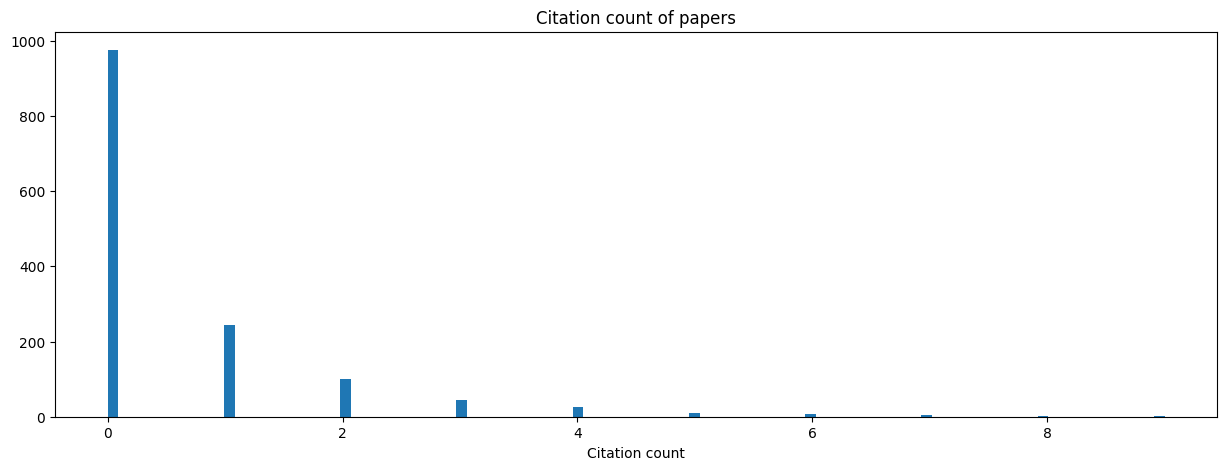

In [18]:
# count of papers which are cited by other papers
citation_count={}
for i in tqdm.trange(len(citation_graph)):
    citation_count[i]=0
    for j in citation_graph.loc[i,'Cited_PaperId']:
        if j in id_to_index:
            citation_count[i]=citation_count[i]+1



# sort the citation count
sorted_citation_count=sorted(citation_count.items(), key=lambda x: x[1],reverse=True)
print(sorted_citation_count)

# plot the citation count
plt.figure(figsize=(15,5))
# frequency of citation count
plt.hist(citation_count.values(),bins=100)
plt.xlabel('Citation count')
plt.title('Citation count of papers')


Top 10 countries with most number of papers will be assigned a unique color and rest will be assigned a common color

In [23]:

top_10_countries=citation_graph['Country'].value_counts()[:10].index
top_10_countries

Index(['United States', 'United Kingdom', 'Germany', 'Canada', 'France',
       'Italy', 'China', 'Israel', 'Australia', 'Switzerland'],
      dtype='object')

Top 10 countries with most papers make up around 87% of the total papers

In [40]:
print(100*np.sum(citation_graph['Country'].value_counts()[:10])/len(citation_graph))

87.41159830268741


Size of node is proportional to number of times a paper is cited .Color of node is based on country of paper

In [29]:
from pyvis.network import Network
net=Network(notebook=True)
for node in graph:
    group=graph[node]['country']
    if group in top_10_countries:
        # change str to index in top 10 countries
        group=top_10_countries.get_loc(group)
    else:
        group=10
    net.add_node(node,size=citation_count[node],group=group)


# add edges
for node in graph:
    
    for edge in graph[node]['Cited_PaperId']:
        net.add_edge(node,edge)

net.show_buttons(filter_=['physics'])
net.save_graph('citation_data/citation_graph_2012_2.html')


### Authors with most papers

In [31]:
author_count={}

for i in tqdm.tqdm(range(len(df))):
    author=df.loc[i,'Author']
    author_count[author]=author_count.get(author,0)+1
# top 100 authors
sorted_author_count=sorted(author_count.items(),key=lambda x:x[1],reverse=True)
sorted_author_count
# save as json
with open('citation_data/author_count.json','w') as f:
    json.dump(sorted_author_count,f)


100%|██████████| 49317/49317 [00:01<00:00, 48223.73it/s]


In [32]:
top_100_authors=sorted_author_count[:100]

### Top 10 Authors with most papers

In [42]:
top_10_authors=top_100_authors[:10]
top_10_authors

[('Sergey Levine', 102),
 ('Yoshua Bengio', 89),
 ('Michael Jordan', 88),
 ('Pieter Abbeel', 76),
 ('Lawrence Carin', 76),
 ('Masashi Sugiyama', 63),
 ('Francis Bach', 63),
 ('Le Song', 61),
 ('Pradeep Ravikumar', 60),
 ('Remi Munos', 58)]

### Collaborations network for top 100 authors
- Edge: If two authors have collaborated on a paper
- Weight of edge : Number of times they have collaborated
- Size of node : Number of papers written by author

Getting the number of papers on which two authors have collaborated on all combinations of top 100 authors.

In [33]:

collobration=pd.DataFrame(columns=['Author1','Author2','Weight'])

for author1 in top_100_authors:
    for author2 in top_100_authors:
        if(author1!=author2):
            # find number of papers they worked on together using title
            
            title1=df[df['Author']==author1[0]]['Title']
            title2=df[df['Author']==author2[0]]['Title']
            
            common_papers=len(set(title1).intersection(set(title2)))
            if(common_papers>0):
                collobration.loc[len(collobration)]=[author1[0],author2[0],common_papers]
collobration=collobration.sort_values(by='Weight',ascending=False)
collobration.head()
# collobration.to_csv('citation_data/collobration.csv',index=False)
collobration=pd.read_csv('citation_data/collobration.csv')


,Author1,Author2,Weight
159,Tie-Yan Liu,Tao Qin,34
290,Tao Qin,Tie-Yan Liu,34
449,Gang Niu,Masashi Sugiyama,28
36,Masashi Sugiyama,Gang Niu,28
211,Zhaoran Wang,Zhuoran Yang,26
...,...,...,...
230,Pushmeet Kohli,Antonio Torralba,1
229,Pushmeet Kohli,Mohammad Norouzi,1
228,Pushmeet Kohli,Shimon Whiteson,1
227,Pushmeet Kohli,Oriol Vinyals,1


In [34]:
# remove 1 from weight
collobration['Weight']=collobration['Weight']-1
# covnert int64 to int32
collobration['Weight']=collobration['Weight'].astype('int32')

### Creating Colloborative Network

In [36]:
from pyvis.network import Network
net = Network(notebook=True)


for author in top_100_authors:
    net.add_node(author[0], size=author[1])

for i in range(len(collobration)):
    net.add_edge(collobration.loc[i,'Author1'], collobration.loc[i,'Author2'],value=int(collobration.loc[i,'Weight']))

net.save_graph("citation_data/collobration2.html")

